# TF-IDF&TextRank
Goal: csv로 정리된 lyrics들을 TF-IDF로 벡터화한 뒤, textrank 알고리즘을 돌려서 top keyword를 얻어내는 것이 목표

## 환경설정

In [ ]:
from google.colab import drive
from os.path import join
ROOT = "/content/gdrive"
drive.mount(ROOT)
MY_GOOGLE_DRIVE_PATH = '/content/gdrive/Shareddrives/23-2 DataMining TeamProject'
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH) # 프로젝트 경로

Mounted at /content/gdrive


In [ ]:
# import
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
import networkx as nx #graph
import matplotlib.pyplot as plt #graph
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize # tokenize
from nltk.corpus import stopwords # stopwords
from sklearn.feature_extraction.text import TfidfVectorizer #TF-IDF
from sklearn.metrics.pairwise import cosine_similarity #cosine similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# csv 파일에서 lyrics 가져오기
MUSIC_FILE = 'music_lyrics.csv'
MUSIC_PATH = join(PROJECT_PATH, MUSIC_FILE)
lyrics = pd.read_csv(MUSIC_PATH)

## Data analysis

In [ ]:
lyrics.shape

(804, 7)

In [ ]:
lyrics.head(5)

,song,artist,album,released_date,genre,like,lyrics
0,Youngblood,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"86,457",Remember the words\nyou told me\nlove me 'til ...
1,Teeth,5 Seconds of Summer,CALM,2020.03.27,POP,"16,857",Some days\nyou're the only thing I know\nOnly ...
2,Who Do You Love,"The Chainsmokers, 5 Seconds of Summer",World War Joy,2019.12.06,일렉트로니카,"48,329",Found cigarettes\nin your Fendi coat\nEven tho...
3,Teeth,5 Seconds of Summer,13 Reasons Why (Season 3),2019.08.23,"POP, 국외드라마","14,753",Some days\nyou're the only thing I know\nOnly ...
4,Ghost Of You,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"12,521",Here I am waking up\nstill can't sleep on your...


In [ ]:
lyrics.dtypes

song             object
artist           object
album            object
released_date    object
genre            object
like             object
lyrics           object
dtype: object

In [ ]:
len(lyrics)

804

In [ ]:
lyrics.count()

song             804
artist           804
album            804
released_date    804
genre            804
like             804
lyrics           804
dtype: int64

In [ ]:
lyrics.describe().transpose()

,count,unique,top,freq
song,804,745,Last Christmas,5
artist,804,215,Maroon 5,12
album,804,602,Nine Track Mind (Deluxe Edition),5
released_date,804,475,2011.01.01,11
genre,804,27,POP,428
like,804,781,"5,367",3
lyrics,804,781,D-D-Daytrip took it to ten hey\nBaby back ayy ...,3


## Preprocessing

In [ ]:
lyrics = lyrics.drop_duplicates(subset=['song','artist'], ignore_index=True)

In [ ]:
# cut sentences
# \n으로 된 것을 .으로 잘라준다
lyrics['lyrics'] = lyrics['lyrics'].str.replace('\n', '. ').to_frame()
lyrics.head()

<ipython-input-12-44db28206b9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyrics['lyrics'] = lyrics['lyrics'].str.replace('\n', '. ').to_frame()


,song,artist,album,released_date,genre,like,lyrics
0,Youngblood,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"86,457",Remember the words. you told me. love me 'til ...
1,Teeth,5 Seconds of Summer,CALM,2020.03.27,POP,"16,857",Some days. you're the only thing I know. Only ...
2,Who Do You Love,"The Chainsmokers, 5 Seconds of Summer",World War Joy,2019.12.06,일렉트로니카,"48,329",Found cigarettes. in your Fendi coat. Even tho...
3,Ghost Of You,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"12,521",Here I am waking up. still can't sleep on your...
4,She Looks So Perfect,5 Seconds of Summer,5 Seconds Of Summer,2014.01.01,록/메탈,"7,580",Hey-hey hey-hey hey-hey hey. Hey-hey hey-hey h...


In [ ]:
# tokenize preparation
# 토큰화하기 위한 준비과정
lyrics['sentences'] = lyrics['lyrics'].apply(sent_tokenize)

In [ ]:
# download stopword from nltk
# 불용어를 다운받기
stop_words = stopwords.words('english')

# tokenization function
# 한 노래의 가사를 여러 문장으로 나누고, 문장 안을 단어로 토큰화해주는 함수
def lyrics_tokenization(sentences):
    return [word_tokenize(sentence) for sentence in sentences]

# preprocess function
# 알파벳으로만, 소문자만, 불용어 삭제, 있는 단어로만 하도록 정제
def lyric_preprocessing(sentence):
  # make only with alphabet and lower
  sentence = [re.sub(r'[^a-zA-z\s]', '', word).lower() for word in sentence]

  # is not stop_word but word
  return [word for word in sentence if word not in stop_words and word]

# apply preprocess_sentence function to all sentences
# 위 과정을 모든 row에 적용
def lyrics_preprocessing(sentences):
    return [lyric_preprocessing(sentence) for sentence in sentences]

In [ ]:
lyrics['tokenized_sentences'] = lyrics['sentences'].apply(lyrics_tokenization)
lyrics['tokenized_sentences'] = lyrics['tokenized_sentences'].apply(lyrics_preprocessing)

In [ ]:
# 불용어 삭제하면서 단어가 아예 없어진 빈 sentence 삭제
i = 0
outer_range = len(lyrics['tokenized_sentences'])

while(i < outer_range):

  j = 0
  inner_range = len(lyrics['tokenized_sentences'][i])

  while(j < inner_range):

    if(len(lyrics['tokenized_sentences'][i][j]) == 0):
      del lyrics['tokenized_sentences'][i][j]
      del lyrics['sentences'][i][j]
      inner_range = inner_range - 1
      continue
    else:
      j = j + 1

  i = i + 1

In [ ]:
lyrics.head()

,song,artist,album,released_date,genre,like,lyrics,sentences,tokenized_sentences
0,Youngblood,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"86,457",Remember the words. you told me. love me 'til ...,"[Remember the words., you told me., love me 't...","[[remember, words], [told], [love, til, day, d..."
1,Teeth,5 Seconds of Summer,CALM,2020.03.27,POP,"16,857",Some days. you're the only thing I know. Only ...,"[Some days., you're the only thing I know., On...","[[days], [thing, know], [thing, burning], [nig..."
2,Who Do You Love,"The Chainsmokers, 5 Seconds of Summer",World War Joy,2019.12.06,일렉트로니카,"48,329",Found cigarettes. in your Fendi coat. Even tho...,"[Found cigarettes., in your Fendi coat., Even ...","[[found, cigarettes], [fendi, coat], [even, th..."
3,Ghost Of You,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"12,521",Here I am waking up. still can't sleep on your...,"[Here I am waking up., still can't sleep on yo...","[[waking], [still, ca, nt, sleep, side], [coff..."
4,She Looks So Perfect,5 Seconds of Summer,5 Seconds Of Summer,2014.01.01,록/메탈,"7,580",Hey-hey hey-hey hey-hey hey. Hey-hey hey-hey h...,"[Hey-hey hey-hey hey-hey hey., Hey-hey hey-hey...","[[heyhey, heyhey, heyhey, hey], [heyhey, heyhe..."


In [ ]:
len(lyrics)

758

## Sentence Embedding: TF-IDF
노래 하나에 들어있는 여러 문장들을 각 문장마다 하나의 벡터가 되도록 sentence -> vector로 바꿔주는 과정 = 이를 TF-IDF와 cosine similarity를 이용해서 구현한다

In [ ]:
# 예시로 볼 song
SAMPLE_NUMBER = 99

In [ ]:
# TF-IDF 모델 사용을 위해 한 문장 내 단어들을 ,가 아닌 하나의 string으로 정제
i = 0
new = [[] for i in range(804)]
for music in lyrics['tokenized_sentences']:
  for sentence in music:
    new[i].append(' '.join(sentence))
  i = i+1

lyrics['tokenized_sentences'] = pd.Series(new).to_frame()
lyrics.head()

,song,artist,album,released_date,genre,like,lyrics,sentences,tokenized_sentences
0,Youngblood,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"86,457",Remember the words. you told me. love me 'til ...,"[Remember the words., you told me., love me 't...","[remember words, told, love til day die, surre..."
1,Teeth,5 Seconds of Summer,CALM,2020.03.27,POP,"16,857",Some days. you're the only thing I know. Only ...,"[Some days., you're the only thing I know., On...","[days, thing know, thing burning, nights grow ..."
2,Who Do You Love,"The Chainsmokers, 5 Seconds of Summer",World War Joy,2019.12.06,일렉트로니카,"48,329",Found cigarettes. in your Fendi coat. Even tho...,"[Found cigarettes., in your Fendi coat., Even ...","[found cigarettes, fendi coat, even though eve..."
3,Ghost Of You,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"12,521",Here I am waking up. still can't sleep on your...,"[Here I am waking up., still can't sleep on yo...","[waking, still ca nt sleep side, coffee cup, l..."
4,She Looks So Perfect,5 Seconds of Summer,5 Seconds Of Summer,2014.01.01,록/메탈,"7,580",Hey-hey hey-hey hey-hey hey. Hey-hey hey-hey h...,"[Hey-hey hey-hey hey-hey hey., Hey-hey hey-hey...","[heyhey heyhey heyhey hey, heyhey heyhey heyhe..."


In [ ]:
#TF-IDF로 sentence embedding
def sentences_vetorization(tokenized_sentences):
  documents = tokenized_sentences
  tf_idf_model = TfidfVectorizer().fit(documents)

  word_id_list = sorted(tf_idf_model.vocabulary_.items(), key=lambda x: x[1], reverse=False)
  word_list = [x[0] for x in word_id_list]

  tf_idf_df = pd.DataFrame(tf_idf_model.transform(documents).toarray(), columns = word_list)

  return tf_idf_df

In [ ]:
# make cosine similarity matrix
def similarity_matrix(sentence_embedding):
  cos_sim_df = pd.DataFrame(cosine_similarity(sentence_embedding, sentence_embedding)).to_numpy()
  return cos_sim_df

In [ ]:
lyrics['SentenceEmbedding'] = lyrics['tokenized_sentences'].apply(sentences_vetorization)
lyrics['SimMatrix'] = lyrics['SentenceEmbedding'].apply(similarity_matrix)

In [ ]:
# SAMPLE_NUMBER번째 music의 sentenceEmbedding 값 보기
lyrics['SentenceEmbedding'][SAMPLE_NUMBER]

,actual,always,anna,arrangement,back,bad,best,betwixt,bit,blondness,...,us,wait,walks,washes,way,wedded,weirdness,well,whole,woods
0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.63973,0.0,0.426017,0.00000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.426017,0.00000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.0,0.0,0.57735,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
86,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.57735,0.0,0.0,0.0,0.0
87,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
88,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0


In [ ]:
# SAMPLE_NUMBER번째 music의 SimMatrix 값 보기
lyrics['SimMatrix'][SAMPLE_NUMBER]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

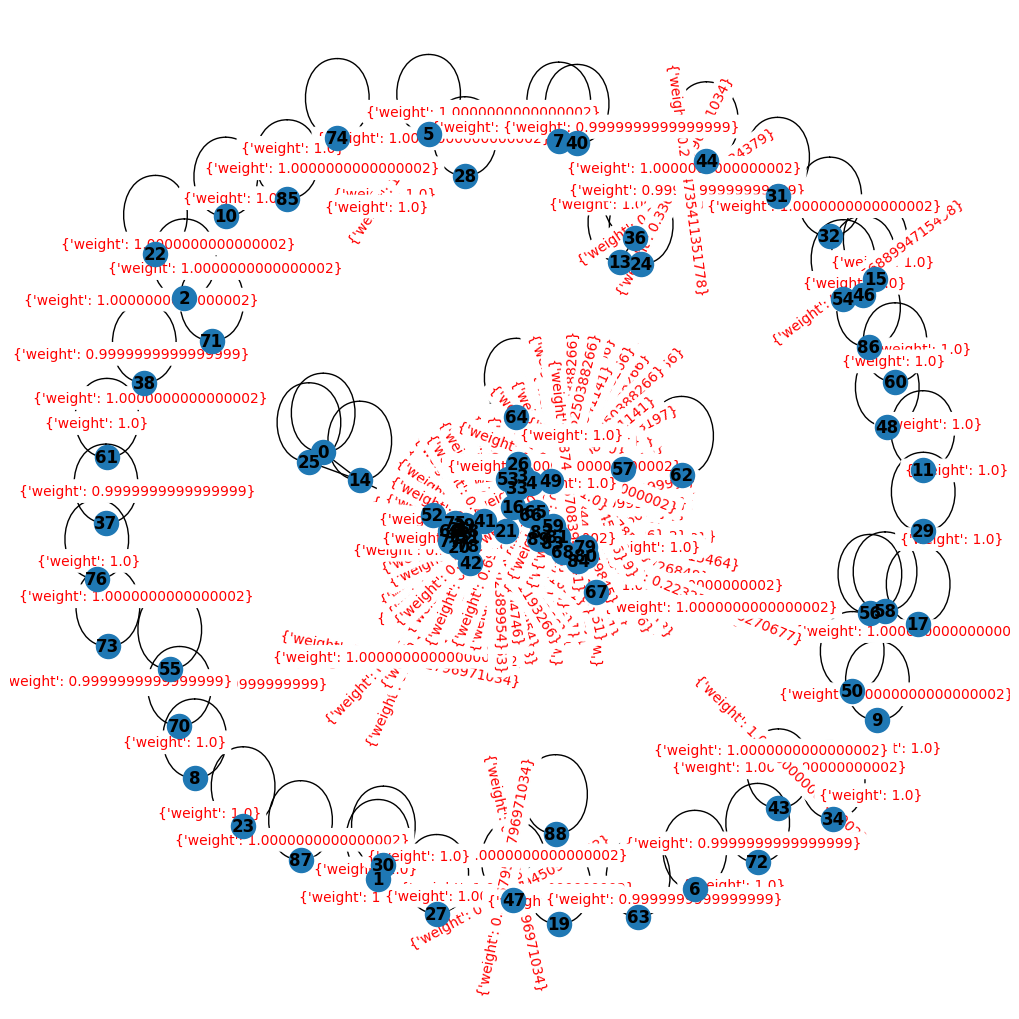

In [ ]:
# 유사도 행렬을 그래프로 나타내기
sim_matrix = lyrics['SimMatrix'][SAMPLE_NUMBER]
nx_graph = nx.from_numpy_array(sim_matrix)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
plt.show()

In [ ]:
lyrics.head()

,song,artist,album,released_date,genre,like,lyrics,sentences,tokenized_sentences,SentenceEmbedding,SimMatrix
0,Youngblood,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"86,457",Remember the words. you told me. love me 'til ...,"[Remember the words., you told me., love me 't...","[remember words, told, love til day die, surre...",around away baby back beat believe ...,"[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Teeth,5 Seconds of Summer,CALM,2020.03.27,POP,"16,857",Some days. you're the only thing I know. Only ...,"[Some days., you're the only thing I know., On...","[days, thing know, thing burning, nights grow ...",alive apologize away beating bed ...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,Who Do You Love,"The Chainsmokers, 5 Seconds of Summer",World War Joy,2019.12.06,일렉트로니카,"48,329",Found cigarettes. in your Fendi coat. Even tho...,"[Found cigarettes., in your Fendi coat., Even ...","[found cigarettes, fendi coat, even though eve...",access acting admit alibi always baby...,"[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Ghost Of You,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"12,521",Here I am waking up. still can't sleep on your...,"[Here I am waking up., still can't sleep on yo...","[waking, still ca nt sleep side, coffee cup, l...",always away better ca chase...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,She Looks So Perfect,5 Seconds of Summer,5 Seconds Of Summer,2014.01.01,록/메탈,"7,580",Hey-hey hey-hey hey-hey hey. Hey-hey hey-hey h...,"[Hey-hey hey-hey hey-hey hey., Hey-hey hey-hey...","[heyhey heyhey heyhey hey, heyhey heyhey heyhe...",alone american amount anything appa...,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Applying Textrank Algorithm

In [ ]:
# 노래를 몇 줄로 요약할 지
SENT_PICK_NUM = 5

In [ ]:
# Textrank 알고리즘 적용하여 score 계산
def calculate_score(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)
    return scores

In [ ]:
lyrics['score'] = lyrics['SimMatrix'].apply(calculate_score)
lyrics[['SimMatrix', 'score']]

,SimMatrix,score
0,"[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.00909090909090909, 1: 0.0090909090909090..."
1,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.010638297872340425, 1: 0.010914430408765..."
2,"[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.01282051282051282, 1: 0.0128205128205128..."
3,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.023809523809523808, 1: 0.023809523809523..."
4,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.017857142857142863, 1: 0.017857142857142..."
...,...,...
753,"[[1.0, 0.3900928163351513, 0.0, 0.0, 0.2870938...","{0: 0.012469483027381878, 1: 0.016818451575411..."
754,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.010869565217391304, 1: 0.010869565217391..."
755,"[[0.9999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.018867924528301886, 1: 0.018867924528301..."
756,"[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.02, 1: 0.01809853181076511, 2: 0.0153843..."


In [ ]:
# SAMPLE_NUMBER번째 노래의 모든 문장들의 score 확인
lyrics['score'][SAMPLE_NUMBER]

{0: 0.009758825600823494,
 1: 0.011111111111111112,
 2: 0.011111111111111112,
 3: 0.00790098315701111,
 4: 0.00790098315701111,
 5: 0.011111111111111112,
 6: 0.011111111111111112,
 7: 0.011111111111111113,
 8: 0.011111111111111112,
 9: 0.011111111111111112,
 10: 0.011111111111111112,
 11: 0.011111111111111112,
 12: 0.014534194377442581,
 13: 0.011410752980259427,
 14: 0.009203046695943917,
 15: 0.011253219237835586,
 16: 0.006049581260787509,
 17: 0.011111111111111112,
 18: 0.014534194377442581,
 19: 0.011111111111111112,
 20: 0.012501625934236753,
 21: 0.014100058364992216,
 22: 0.011111111111111112,
 23: 0.011111111111111112,
 24: 0.010836656155642659,
 25: 0.009558345075800277,
 26: 0.009888925086407234,
 27: 0.011111111111111112,
 28: 0.011111111111111112,
 29: 0.011111111111111112,
 30: 0.011111111111111112,
 31: 0.011111111111111112,
 32: 0.011111111111111112,
 33: 0.008715943941112731,
 34: 0.011111111111111112,
 35: 0.014534194377442581,
 36: 0.011085924197431242,
 37: 0.011111

In [ ]:
# 노래에서 score SENT_PICK_NUM등까지의 문장을 추출
def ranked_sentences(sentences, scores, n=SENT_PICK_NUM):

    top_scores = sorted(((scores[i],s) for i,s in enumerate(sentences)),reverse=True)
    top_n_sentences = [sentence for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)

In [ ]:
lyrics['summary'] = lyrics.apply(lambda x: ranked_sentences(x.sentences,x.score), axis=1)

In [ ]:
# n번째 노래를 SENT_PICK_NUM줄 요약하여 도출한 결과 확인
print('\033[1m', "Song: ", '\033[0m\n', lyrics['song'][SAMPLE_NUMBER], "(", lyrics['artist'][SAMPLE_NUMBER], ")", "\n")
print('\033[1m', "Full lyrics:", '\033[0m')
print(lyrics['lyrics'][SAMPLE_NUMBER], "\n")
print('\033[1m', "Top ",SENT_PICK_NUM," summarized lyrics:", '\033[0m')
print(lyrics['summary'][SAMPLE_NUMBER])

 Song:  
 Fixer Upper ( Christophe Beck, Cast - Frozen ) 

 Full lyrics: 
What's the issue dear. Why are you holding back from. such a man. Is it the clumpy way he walks. Or the grumpy way he talks. Or the pear shaped square shaped. Weirdness of his feet. And though we know he washes. Well he always ends up sort of. smelly. But you'll never meet a fellow. who's as. Sensitive and sweet. So he's a bit of a fixer upper. So he's got a few flaws. Like his peculiar brain dear. His thing with the reindeer. That's a little outside of. nature's laws. So he's a bit of a fixer upper. but this we're certain of. You can fix this fixer upper. Up with a little bit of love. Can we please just. Stop talking about this. We've got a real actual problem. here. I'll say So tell me dear. Is it the way that he runs scared. Or that he's socially impaired. Or that he only likes to tinkle. in the woods what. Are you holding back your. Fondness due to his unmanly. blondness. Or the way he covers. Up that he's th

In [ ]:
# 결과적으로 나온 dataframe
lyrics.head()

,song,artist,album,released_date,genre,like,lyrics,sentences,tokenized_sentences,SentenceEmbedding,SimMatrix,score,summary
0,Youngblood,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"86,457",Remember the words. you told me. love me 'til ...,"[Remember the words., you told me., love me 't...","[remember words, told, love til day die, surre...",around away baby back beat believe ...,"[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.00909090909090909, 1: 0.0090909090909090...",yeah you need it. yeah you need it. yeah you n...
1,Teeth,5 Seconds of Summer,CALM,2020.03.27,POP,"16,857",Some days. you're the only thing I know. Only ...,"[Some days., you're the only thing I know., On...","[days, thing know, thing burning, nights grow ...",alive apologize away beating bed ...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.010638297872340425, 1: 0.010914430408765...",Don't know if you love me. I don't know. Don't...
2,Who Do You Love,"The Chainsmokers, 5 Seconds of Summer",World War Joy,2019.12.06,일렉트로니카,"48,329",Found cigarettes. in your Fendi coat. Even tho...,"[Found cigarettes., in your Fendi coat., Even ...","[found cigarettes, fendi coat, even though eve...",access acting admit alibi always baby...,"[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.01282051282051282, 1: 0.0128205128205128...",You’ve been acting so conspicuous. I wanna kno...
3,Ghost Of You,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"12,521",Here I am waking up. still can't sleep on your...,"[Here I am waking up., still can't sleep on yo...","[waking, still ca nt sleep side, coffee cup, l...",always away better ca chase...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.023809523809523808, 1: 0.023809523809523...",like I always do. like I always do. like I alw...
4,She Looks So Perfect,5 Seconds of Summer,5 Seconds Of Summer,2014.01.01,록/메탈,"7,580",Hey-hey hey-hey hey-hey hey. Hey-hey hey-hey h...,"[Hey-hey hey-hey hey-hey hey., Hey-hey hey-hey...","[heyhey heyhey heyhey hey, heyhey heyhey heyhe...",alone american amount anything appa...,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.017857142857142863, 1: 0.017857142857142...",I got your name tattooed. I got your name tatt...


In [ ]:
lyrics['summary'][0]

'yeah you need it. yeah you need it. yeah you need it. yeah I need it. yeah I need it.'

# Clustering

K-means

In [ ]:
pip install pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395103 sha256=7215aa5ed5541e14a0acb7b844306573c0045a5910f8a4dadf1c498c2cbd5f3c
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering


In [ ]:
from sklearn.cluster import KMeans
from pyclustering.cluster import kmedoids
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [ ]:
lyrics['clustering_sentences'] = lyrics['tokenized_sentences']

for index,sentence in enumerate(lyrics['clustering_sentences']):
  sentence_to_string = ''
  for word in sentence:
    sentence_to_string += word + ' '
  lyrics['clustering_sentences'][index] = sentence_to_string

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df = 5, ngram_range=(1,5))
tfidf_vectorizer.fit(lyrics['clustering_sentences'])
vector = tfidf_vectorizer.transform(lyrics['clustering_sentences']).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

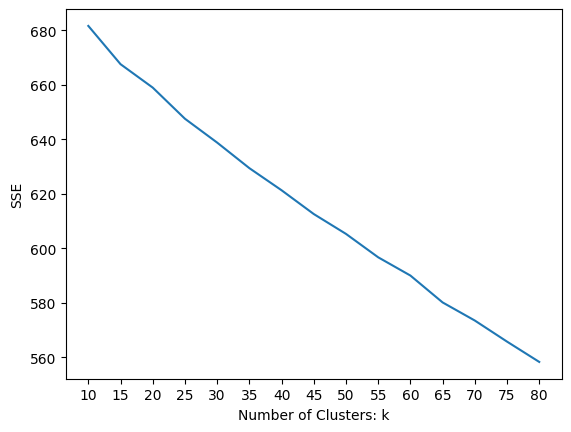

In [ ]:
k_means_sse = []
n_cluster = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]
for k in n_cluster:
  temp_kmeans = KMeans(n_clusters= k).fit(vector)
  k_means_sse.append(temp_kmeans.inertia_)

plt.plot(n_cluster,k_means_sse)
plt.xticks(n_cluster)
plt.xlabel("Number of Clusters: k")
plt.ylabel("SSE")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters= 40).fit(vector)
lyrics['kmeans_cluster_result'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
lyrics['pred_silhouette'] = silhouette_samples(vector, labels=lyrics['kmeans_cluster_result'])
lyrics.head()

,song,artist,album,released_date,genre,like,lyrics,sentences,tokenized_sentences,SentenceEmbedding,SimMatrix,score,summary,clustering_sentences,kmeans_cluster_result,pred_silhouette
0,Youngblood,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"86,457",Remember the words. you told me. love me 'til ...,"[Remember the words., you told me., love me 't...","[remember words, told, love til day die, surre...",around away baby back beat believe ...,"[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.00909090909090909, 1: 0.0090909090909090...",yeah you need it. yeah you need it. yeah you n...,remember words told love til day die surrender...,23,0.081074
1,Teeth,5 Seconds of Summer,CALM,2020.03.27,POP,"16,857",Some days. you're the only thing I know. Only ...,"[Some days., you're the only thing I know., On...","[days, thing know, thing burning, nights grow ...",alive apologize away beating bed ...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.010638297872340425, 1: 0.010914430408765...",Don't know if you love me. I don't know. Don't...,days thing know thing burning nights grow cold...,4,-0.009000
2,Who Do You Love,"The Chainsmokers, 5 Seconds of Summer",World War Joy,2019.12.06,일렉트로니카,"48,329",Found cigarettes. in your Fendi coat. Even tho...,"[Found cigarettes., in your Fendi coat., Even ...","[found cigarettes, fendi coat, even though eve...",access acting admit alibi always baby...,"[[1.0000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.01282051282051282, 1: 0.0128205128205128...",You’ve been acting so conspicuous. I wanna kno...,found cigarettes fendi coat even though even s...,7,-0.025238
3,Ghost Of You,5 Seconds of Summer,Youngblood (Deluxe),2018.06.15,록/메탈,"12,521",Here I am waking up. still can't sleep on your...,"[Here I am waking up., still can't sleep on yo...","[waking, still ca nt sleep side, coffee cup, l...",always away better ca chase...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.023809523809523808, 1: 0.023809523809523...",like I always do. like I always do. like I alw...,waking still ca nt sleep side coffee cup lipst...,16,0.001259
4,She Looks So Perfect,5 Seconds of Summer,5 Seconds Of Summer,2014.01.01,록/메탈,"7,580",Hey-hey hey-hey hey-hey hey. Hey-hey hey-hey h...,"[Hey-hey hey-hey hey-hey hey., Hey-hey hey-hey...","[heyhey heyhey heyhey hey, heyhey heyhey heyhe...",alone american amount anything appa...,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","{0: 0.017857142857142863, 1: 0.017857142857142...",I got your name tattooed. I got your name tatt...,heyhey heyhey heyhey hey heyhey heyhey heyhey ...,27,-0.015587


In [ ]:
pred_ss = silhouette_score(vector, labels=lyrics['kmeans_cluster_result'])
print(f'예측 silhouette score: {pred_ss: .4f}')

예측 silhouette score:  0.0394


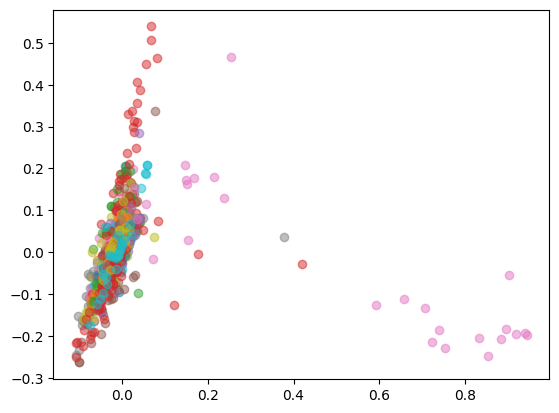

In [ ]:
pca = PCA(2)

df = pca.fit_transform(vector)
df = pd.DataFrame(df)
df['label'] = kmeans.labels_
u_labels = np.unique(kmeans.labels_)

for i in u_labels:
  x = df[df['label']==i][0]
  y = df[df['label']==i][1]
  plt.scatter(x=x, y=y,alpha=0.5,label=i)
plt.show()

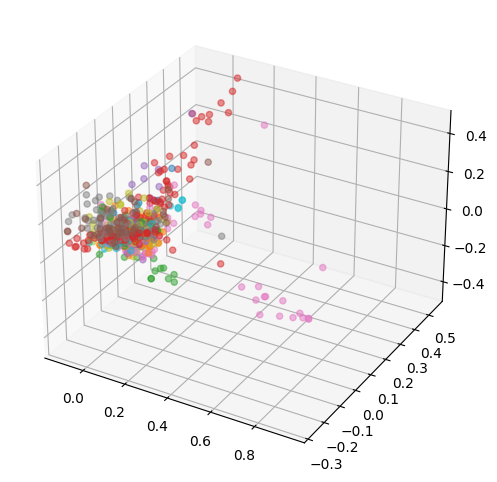

In [ ]:
pca = PCA(3)

df = pca.fit_transform(vector)
df = pd.DataFrame(df)
df['label'] = kmeans.labels_
u_labels = np.unique(kmeans.labels_)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

for i in u_labels:
  x = df[df['label']==i][0]
  y = df[df['label']==i][1]
  z = df[df['label']==i][2]
  ax.scatter(x,y,z,alpha=0.5,label=i)
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.65, min_samples=3, metric="cosine")
dbscan_result = dbscan.fit_predict(vector)
lyrics['DBSCAN_cluster_result'] = dbscan_result

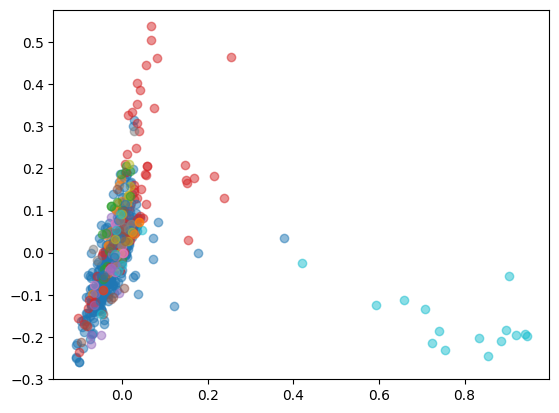

In [ ]:
pca = PCA(2)

dbscan_df = pca.fit_transform(vector)
dbscan_df = pd.DataFrame(dbscan_df)
dbscan_df['label'] = dbscan_result
u_labels = np.unique(dbscan_result)

for i in u_labels:
  x = dbscan_df[dbscan_df['label']==i][0]
  y = dbscan_df[dbscan_df['label']==i][1]
  plt.scatter(x=x, y=y,alpha=0.5,label=i)
plt.show()

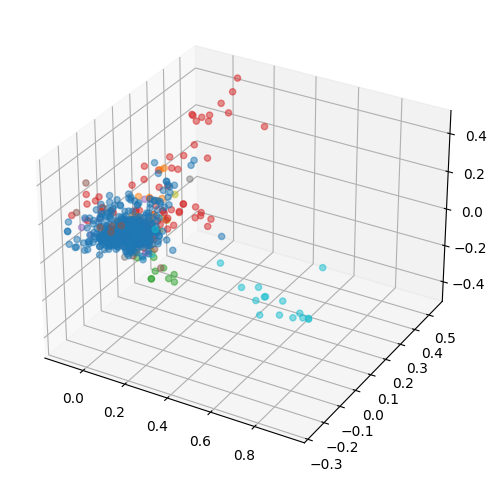

In [ ]:
pca = PCA(3)

dbscan_df = pca.fit_transform(vector)
dbscan_df = pd.DataFrame(dbscan_df)
dbscan_df['label'] = dbscan_result
u_labels = np.unique(dbscan_result)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

for i in u_labels:
  x = dbscan_df[dbscan_df['label']==i][0]
  y = dbscan_df[dbscan_df['label']==i][1]
  z = dbscan_df[dbscan_df['label']==i][2]
  ax.scatter(x,y,z,alpha=0.5,label=i)
plt.show()


In [ ]:
db_pred_ss = silhouette_score(vector, labels=lyrics['DBSCAN_cluster_result'])
print(f'예측 silhouette score: {db_pred_ss: .4f}')

예측 silhouette score:  0.0178


In [ ]:
print("KMeans clustering result")
for cluster_num in set(kmeans.labels_):
        print("cluster num : {}".format(cluster_num))
        temp_df = lyrics[lyrics['kmeans_cluster_result'] == cluster_num] # cluster num 별로 조회
        for title in temp_df['song']:
            print(title) # 제목으로 살펴보자
        print()

KMeans clustering result
cluster num : 0
Let's Get It Started
Money
Paint The Town Red
Boss Bitch
Feelings
One Thing
as long as you care

cluster num : 1
YOU & I (feat. Khalid)
South of the Border (feat. Camila Cabello & Cardi B)
Perfect
Thinking Out Loud
Falling
Dark Horse (Feat. Juicy J)
Mean It
Night Changes
Breaking My Heart
Fallin' All In You
Call You Mine (feat. Bebe Rexha)
Out of Time

cluster num : 2
Snooze
International Love (Feat. Chris Brown)
The Scientist
Bad Habits
abcdefu
Rum n Tequila
Leave Em Alone (Feat. City Girls, PnB Rock)
Spell (Album Version)
Billie Jean
Hey Jude (Love Version)
Hey Jude (Remastered 2009)
MELTDOWN (Feat. Drake)
Water
One Moment In Time

cluster num : 3
Time
My Happy Ending
Crazy In Love
That’s Not How This Works (feat. Dan + Shay)
Left and Right (Feat. Jung Kook of BTS)
Sad in Hawaii
Viva La Vida
Paradise
Disaster
Shape of You
All of the Stars
작은 것들을 위한 시 (Boy With Luv) (Feat. Halsey)
Believer
Love On The Weekend
Mistletoe
I'm the One (Feat. Justin

In [ ]:
print("DBscan clustering result")
for cluster_num in set(dbscan_result):
    # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
    if(cluster_num == -1 or cluster_num == 0):
        continue
    else:
        print("cluster num : {}".format(cluster_num))
        temp_df = lyrics[lyrics['DBSCAN_cluster_result'] == cluster_num] # cluster num 별로 조회
        for title in temp_df['song']:
            print(title) # 제목으로 살펴보자
        print()

DBscan clustering result
cluster num : 1
Karma
I Gotta Feeling
you were good to me
Good Life
Let Me Down Slow
Let Me Down Slow
Let It Be (Remastered 2009)
Rush

cluster num : 2
The Good Part
My Happy Ending
I Like It
MIA (Feat. Drake)
Tití Me Preguntó (Explicit Ver.)
Dura (Remix) (Feat. Natti Natasha, Becky G, Bad Bunny)
DÁKITI (Explicit Ver.)
Mayores
Vuelie
Run The World (Girls)
That's What I Like
Runaway Baby
This Love
Havana (Feat. Young Thug)
Swinging at the Stars
Sad in Hawaii
Paradise
Disaster
Get Lucky (feat. Pharrell Williams and Nile Rodgers)
Harder, Better, Faster, Stronger
One More Time
Daft Punk
Get Lucky (Radio Edit - feat. Pharrell Williams and Nile Rodgers)
Dance The Night
z
Eastside
Eastside (Acoustic)
Lucky (Feat. Colbie Caillat)
You And I Both
Guitars and Drugs
Mistletoe
I'm the One (Feat. Justin Bieber, Quavo, Chance the Rapper, Lil Wayne)
CAN'T STOP THE FEELING! (from DreamWorks Animation's "TROLLS")
September (from DreamWorks Animation's "TROLLS")
telepatía
Melting

## word cloud

In [ ]:
words = []

for sentence in lyrics.tokenized_sentences:

  for word in sentence:
    words.append(word)

In [ ]:
from collections import Counter

counter = Counter(words)
counter.most_common(10)

[('love', 208),
 ('know', 167),
 ('yeah', 124),
 ('need', 97),
 ('baby', 97),
 ('like', 95),
 ('nt know', 90),
 ('go ahead gone', 90),
 ('go', 85),
 ('got', 84)]

In [ ]:
from wordcloud import WordCloud

def wordcloud(counter):
  wordCloud = WordCloud(width=1200, height=800, background_color="white", max_words=1000)
  wordCloud.generate_from_frequencies(counter)


  fig = plt.figure(figsize=(6,4))
  plt.imshow(wordCloud, interpolation="bilinear")
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.show()

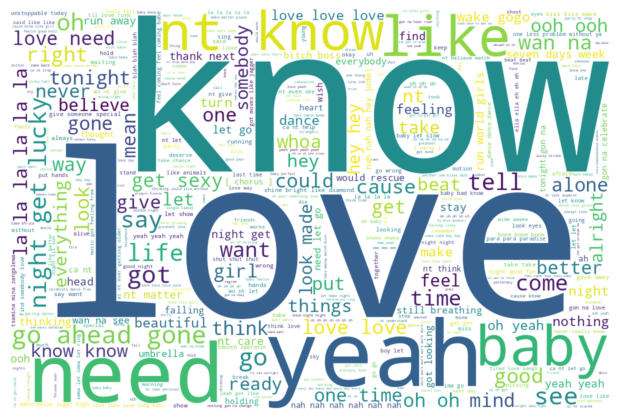

In [ ]:
wordcloud(counter)

# USER

In [ ]:
user_song = input("song: ")
user_artist = input("artist: ")
user_lyrics = input("lyrics: ")

data=[[user_song, user_artist,user_lyrics]]

user_df = pd.DataFrame(data, columns=['song','artist','lyrics'])

user_df['lyrics'] = user_df['lyrics'].replace('\n', '. ').to_frame()
user_df['sentences'] = user_df['lyrics'].apply(sent_tokenize)

user_df['tokenized_sentences'] = user_df['sentences'].apply(lyrics_tokenization)
user_df['tokenized_sentences'] = user_df['tokenized_sentences'].apply(lyrics_preprocessing)

new = []
for music in user_df['tokenized_sentences']:
  for sentence in music:
    new.append(' '.join(sentence))


user_df['tokenized_sentences'] = pd.Series(new).to_frame()
user_df['clustering_sentences'] = user_df['tokenized_sentences']

user_str = ''
for word in user_df['clustering_sentences'][0]:
  user_str += word + ' '

user_df['clustering_sentences'] = user_str


song: Suffer
artist: Charlie Puth
lyrics: Detonate Detonator Baby you you blow my mind You'll tell me wait wait on ya But baby I can't wait all night I go through pictures inside my phone Won't stop tempting me You know what I want Wanna make wanna make love Girl I can't lie I'm just a sucker For a cold hearted lover You make me suffer You make me suffer Don't keep me waiting You should come over Don't make me suffer Don't make me suffer So here we go go again It's like I'm caught under your spell You're wearing black black magic Oh baby don't wear nothing else When I open up this door don't you play Ain't no other man going to make you feel the same Wanna make wanna make love Girl I can't lie I'm just a sucker For a cold hearted lover You make me suffer You make me suffer Don't keep me waiting You should come over Don't make me suffer Don't make me suffer I hate when You get your way But we love you we love you baby So please don't ever change You make me suffer baby You oh I'm just a

In [ ]:
recomm_df = lyrics[['song','artist','lyrics','sentences','tokenized_sentences','clustering_sentences','summary']]
recomm_df = recomm_df.append(user_df, ignore_index=True)

<ipython-input-250-5a74a0fbc98e>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recomm_df = recomm_df.append(user_df, ignore_index=True)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df = 5, ngram_range=(1,5))
tfidf_vectorizer.fit(recomm_df['clustering_sentences'])
user_vector = tfidf_vectorizer.transform(recomm_df['clustering_sentences']).toarray()

In [ ]:
user_kmeans = KMeans(n_clusters= 40).fit(user_vector)
recomm_df['kmeans_cluster_result'] = user_kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
user_dbscan = DBSCAN(eps=0.65, min_samples=3, metric="cosine")
user_dbscan_result = user_dbscan.fit_predict(user_vector)
recomm_df['DBSCAN_cluster_result'] = user_dbscan_result

In [ ]:
k_means_cluster = recomm_df.loc[recomm_df.song == user_song]
k_means_cluster = int(k_means_cluster.kmeans_cluster_result)

k_means_temp_df = recomm_df[recomm_df['kmeans_cluster_result'] == k_means_cluster] # cluster num 별로 조회
k_means_temp_df = k_means_temp_df.drop(len(recomm_df)-1)


In [ ]:
db_cluster = recomm_df.loc[recomm_df.song == user_song]
recommend_lyrics = recomm_df[recomm_df.song != user_song]
recommend_lyrics = recomm_df.drop(labels=db_cluster.index)
db_cluster = int(db_cluster.DBSCAN_cluster_result)

if(db_cluster>0):
  db_temp_df = recommend_lyrics[recommend_lyrics['DBSCAN_cluster_result'] == db_cluster] # cluster num 별로 조회
  recommend_df = pd.concat([k_means_temp_df,db_temp_df])
  recommend_df = recommend_df.drop_duplicated(['song','artist'])
  recommend_df = recommend_df.reset_index()
else:
  recommend_df = k_means_temp_df
  recommend_df = recommend_df.reset_index()

  print("추천 노래 수: ", recommend_df['song'].count())
recommend_df[['song','artist','summary']]

추천 노래 수:  38


,song,artist,summary
0,I Hate U,SZA,Lost ain't no findin' us. Lost ain't no findin...
1,The Weekend,SZA,You're like 9 to 5 I'm the weekend. We got bri...
2,Kill Bill (Feat. Doja Cat),SZA,"I might kill my ex, not the best idea. I might..."
3,Someone Like You,Adele,That for me it isn't over. That for me it isn'...
4,Skyfall (Full Length),Adele,But you'll never have my heart. At skyfall. At...
5,I'm With You,Avril Lavigne,I don't know who you are but I. I'm with you. ...
6,Irreplaceable,Beyonce,So don't you ever for a. second get to thinkin...
7,Shut Up,Black Eyed Peas,Girl I know you're. I love you too. Girl our l...
8,Little Bit (Clean Ver.),Chris Brown,"You ain't gotta stay the night, you can leave ..."
9,International Love (Feat. Chris Brown),Pitbull,don't affect me baby. I didn't know existed. O...
